In [114]:
0#This is Good Practioce for the moment

#Necessary dependencies
!rm -rf /opt/conda/lib/python3.10/site-packages/fsspec*
!pip install fsspec==2024.6.0 --force-reinstall --no-deps
!pip install s3fs

  Using cached fsspec-2024.6.0-py3-none-any.whl.metadata (11 kB)
Using cached fsspec-2024.6.0-py3-none-any.whl (176 kB)
  Using cached fsspec-2024.9.0-py3-none-any.whl.metadata (11 kB)
Using cached fsspec-2024.9.0-py3-none-any.whl (179 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.0
    Uninstalling fsspec-2024.6.0:
      Successfully uninstalled fsspec-2024.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-ai 2.18.1 requires faiss-cpu, which is not installed.
datasets 2.19.2 requires fsspec[http]<=2024.3.1,>=2023.1.0, but you have fsspec 2024.9.0 which is incompatible.
jupyter-scheduler 2.7.1 requires fsspec==2023.6.0, but you have fsspec 2024.9.0 which is incompatible.


Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1581 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [998 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]        
Get:6 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1149 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [51.8 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2499 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2967 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [3045 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-s

In [2]:
# Loading the data

import s3fs
import zipfile
import os

# Set up your S3 bucket and file paths
bucket_name = 'rsna-2024'
file_key = 'RSNA/_output_.zip'
local_zip_path = './_output_.zip'
local_extract_path = './rsna_output/'

# Create an s3fs filesystem object
fs = s3fs.S3FileSystem()

# Download the zip file from S3 to the SageMaker environment
fs.get(f'{bucket_name}/{file_key}', local_zip_path)


[None]

In [3]:
# Make sure the local directory for extraction exists
if not os.path.exists(local_extract_path):
    os.makedirs(local_extract_path)

In [4]:
# Unzip the file in the local SageMaker environment
with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
    zip_ref.extractall(local_extract_path)

In [5]:
# Check if files are extracted successfully
extracted_files = os.listdir(local_extract_path)
print(f"Extracted files: {extracted_files}")

Extracted files: ['cvt_png', '__pycache__']


## Exploring the data

In [28]:

import os

# Path where the unzipped files are stored
data_path = './rsna_output/'

# # List all files and directories in the unzipped data folder++
# for root, dirs, files in os.walk(data_path):
#     print(f"Directory: {root}")
#     for file in files[:3]:  # Display first 3 files in each directory+
#         print(f" - {file}")
#     print()



In [30]:
import os
import s3fs

# Define the S3 bucket and folder
bucket_name = 'rsna-2024'
s3_folder = 'RSNA/'

# Local directory to save the downloaded files
local_directory = './kaggle-files/'

# Create local directory if it doesn't exist
if not os.path.exists(local_directory):
    os.makedirs(local_directory)

# Create an s3fs filesystem object
fs = s3fs.S3FileSystem()

# List files in the S3 folder
files = fs.ls(f'{bucket_name}/{s3_folder}')

# Exclude _output_.zip from the list
files = [file for file in files if '_output_.zip' not in file]

# Download each file from S3 to the local directory
for file in files:
    file_name = file.split('/')[-1]  # Get the file name
    local_file_path = os.path.join(local_directory, file_name)
    
    # Download the file
    fs.get(file, local_file_path)
    print(f"Downloaded {file_name} to {local_file_path}")


Downloaded sample_submission.csv to ./kaggle-files/sample_submission.csv
Downloaded test_series_descriptions.csv to ./kaggle-files/test_series_descriptions.csv
Downloaded train.csv to ./kaggle-files/train.csv
Downloaded train_label_coordinates.csv to ./kaggle-files/train_label_coordinates.csv
Downloaded train_series_descriptions.csv to ./kaggle-files/train_series_descriptions.csv


## Ckeking the data

This code is designed to load and preprocess MRI images for a Kaggle competition on lumbar spine condition classification. Here's a breakdown of the key aspects:

### **Dataset Structure:**
1. **Multiple Image Series**: 
   - The dataset contains three types of images: 
     - *Sagittal T1* (10 images)
     - *Sagittal T2/STIR* (10 images)
     - *Axial T2* (10 images).
   - For each study (`study_id`), these images are stored in subdirectories under a folder (`cvt_png`), organized by series description.

2. **Image Preprocessing**: 
   - The images are loaded in grayscale (`convert('L')`), resized to `(512, 512)` pixels, and then stacked into a 3D array (`C x H x W`) where `C=30` represents the channels from the different image types and slices.
   - Each series is processed separately, and the code ensures up to 10 images are loaded from each of the three series types.

3. **Data Augmentation**: 
   - **Albumentations** is used for applying transformations:
     - Images are resized to `512x512`.
     - Normalization with a mean and standard deviation of `0.5`.

4. **Label Handling**:
   - The labels (for different spine conditions) are extracted from the dataframe, and they are returned alongside the processed images in the `__getitem__()` method.
   
5. **DataLoader**:
   - The `DataLoader` is used for batching, shuffling, and parallel processing of the dataset. It loads the data into batches, in this case with a batch size of `2`, which can be increased during actual training.

6. **Visualization and Testing**: 
   - The code also includes a testing loop to verify the DataLoader’s functionality.
   - It shows a preview of the image (after transforming) by visualizing the first 3 channels, ensuring the images are correctly loaded and augmented.

### **Main Points:**
- The code uses **PyTorch** and **Albumentations** to handle image loading, augmentation, and preprocessing.
- It handles multiple MRI image series per study, loading them into a multi-channel format with up to 30 channels.
- It ensures images are normalized and resized for model input.
- **DataLoader** is set up with batching, pinning memory, and options for multi-threaded loading (although `num_workers=0` here, which can be increased for better performance).
- The data augmentation includes resizing and normalization, but other augmentations like flips or rotations could be added if needed.

Let me know if you'd like help with improving or extending this code!

In [2]:
#Kaggle Files
rd = './kaggle-files'

In [3]:
import pandas as pd

df = pd.read_csv(f'{rd}/train.csv')
df.head()

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild


In [4]:
df = df.fillna(-100)

In [5]:
label2id = {'Normal/Mild': 0, 'Moderate':1, 'Severe':2}
df = df.replace(label2id)
df.head()

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,4646740,0,0,1,2,0,0,0,0,1,...,0,0,0,2,0,0,1,1,1,0
2,7143189,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8785691,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,10728036,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [6]:
CONDITIONS = [
    'Spinal Canal Stenosis', 
    'Left Neural Foraminal Narrowing', 
    'Right Neural Foraminal Narrowing',
    'Left Subarticular Stenosis',
    'Right Subarticular Stenosis'
]

LEVELS = [
    'L1/L2',
    'L2/L3',
    'L3/L4',
    'L4/L5',
    'L5/S1',
]

In [7]:
from torch.utils.data import DataLoader, Dataset

#defining the dataset
class RSNA24Dataset(Dataset):
    def __init__(self, df, phase='train', transform=None):
        self.df = df
        self.transform = transform
        self.phase = phase
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x = np.zeros((IMG_SIZE[0], IMG_SIZE[1], IN_CHANS), dtype=np.uint8)
        t = self.df.iloc[idx]
        st_id = int(t['study_id'])
        label = t[1:].values.astype(np.int64)
        
        # Sagittal T1
        for i in range(0, 10, 1):
            try:
                p = f'./rsna_output/cvt_png/{st_id}/Sagittal T1/{i:03d}.png'
                img = Image.open(p).convert('L')
                img = np.array(img)
                x[..., i] = img.astype(np.uint8)
            except:
                #print(f'failed to load on {st_id}, Sagittal T1')
                pass
            
        # Sagittal T2/STIR
        for i in range(0, 10, 1):
            try:
                p = f'./rsna_output/cvt_png/{st_id}/Sagittal T2_STIR/{i:03d}.png'
                img = Image.open(p).convert('L')
                img = np.array(img)
                x[..., i+10] = img.astype(np.uint8)
            except:
                #print(f'failed to load on {st_id}, Sagittal T2/STIR')
                pass
            
        # Axial T2
        axt2 = glob(f'./rsna_output/cvt_png/{st_id}/Axial T2/*.png')
        axt2 = sorted(axt2)
    
        step = len(axt2) / 10.0
        st = len(axt2)/2.0 - 4.0*step
        end = len(axt2)+0.0001
                
        for i, j in enumerate(np.arange(st, end, step)):
            try:
                p = axt2[max(0, int((j-0.5001).round()))]
                img = Image.open(p).convert('L')
                img = np.array(img)
                x[..., i+20] = img.astype(np.uint8)
            except:
                #print(f'failed to load on {st_id}, Sagittal T2/STIR')
                pass  
            
        assert np.sum(x)>0
            
        if self.transform is not None:
            x = self.transform(image=x)['image']

        x = x.transpose(2, 0, 1)
                
        return x, label


In [8]:
!pip install albumentations

  Using cached albumentations-1.4.14-py3-none-any.whl.metadata (38 kB)
  Using cached scikit_image-0.24.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (14 kB)
  Using cached pydantic-2.9.1-py3-none-any.whl.metadata (146 kB)
  Using cached albucore-0.0.14-py3-none-any.whl.metadata (3.1 kB)
  Using cached eval_type_backport-0.2.0-py3-none-any.whl.metadata (2.2 kB)
  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached pydantic_core-2.23.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.6 kB)
  Using cached tifffile-2024.8.30-py3-none-any.whl.metadata (31 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
Using cached albumentations-1.4.14-py3-none-any.whl (177 kB)
Using cached albucore-0.0.14-py3-none-any.whl (8.5 kB)
Using cached opencv_python_headless-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (49.9 MB)
Using cached p

In [9]:
# Perform A data Augmentation
import albumentations as A

IMG_SIZE = [512, 512]

transforms_val = A.Compose([
    A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
    A.Normalize(mean=0.5, std=0.5)
])

x stat: torch.Size([2, 30, 512, 512]) tensor(-1.) tensor(1.) tensor(-0.6954) tensor(0.3632)
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
         0],
        [0, 0, 1, 2, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 1, 1, 1,
         0]]) torch.Size([2, 25])


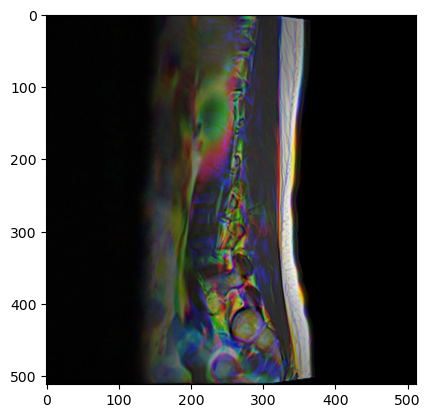

y stat: (512, 512, 3) 0.0 1.0 0.11908135 0.17637749

x stat: torch.Size([2, 30, 512, 512]) tensor(-1.) tensor(1.) tensor(-0.7168) tensor(0.4038)
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]]) torch.Size([2, 25])


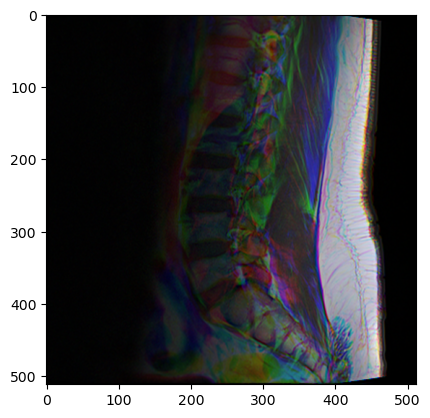

y stat: (512, 512, 3) 0.0 1.0 0.15464914 0.21012934

x stat: torch.Size([2, 30, 512, 512]) tensor(-1.) tensor(1.) tensor(-0.6033) tensor(0.3841)
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
         0]]) torch.Size([2, 25])


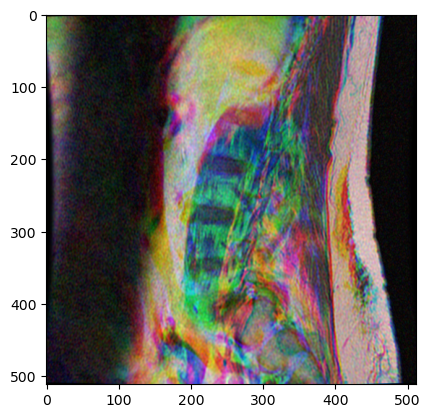

y stat: (512, 512, 3) 0.0 1.0 0.3268126 0.24542229

x stat: torch.Size([2, 30, 512, 512]) tensor(-1.) tensor(1.) tensor(-0.7851) tensor(0.2931)
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
         0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
         1]]) torch.Size([2, 25])


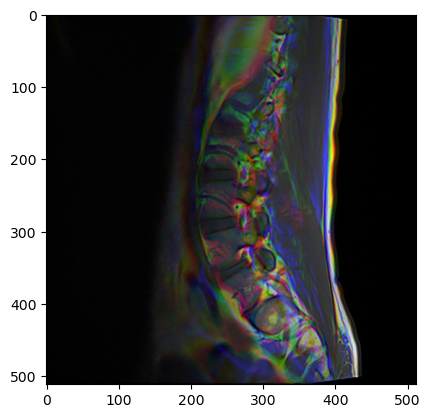

y stat: (512, 512, 3) 0.0 1.0 0.11084941 0.14651673



In [19]:
import numpy as np
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt

IN_CHANS = 30

# Testing DataLoader
tmp_ds = RSNA24Dataset(df, phase='train', transform=transforms_val)
tmp_dl = DataLoader(
            tmp_ds,
            batch_size=2,
            shuffle=False,
            pin_memory=True,
            drop_last=False,
            num_workers=0
            )

for i, (x, t) in enumerate(tmp_dl):
    if i==4:break
    print('x stat:', x.shape, x.min(), x.max(),x.mean(), x.std())
    print(t, t.shape)
    y = x.numpy().transpose(0,2,3,1)[0,...,:3]
    y = (y + 1) / 2
    plt.imshow(y)
    plt.show()
    print('y stat:', y.shape, y.min(), y.max(),y.mean(), y.std())
    print()
plt.close()
del tmp_ds, tmp_dl


In [11]:
!pip install imageio[ffmpeg]


  Using cached imageio_ffmpeg-0.5.1-py3-none-manylinux2010_x86_64.whl.metadata (1.6 kB)
Using cached imageio_ffmpeg-0.5.1-py3-none-manylinux2010_x86_64.whl (26.9 MB)


## Investigating the lesion location


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os

# Load the coordinates data
coordinates_df = pd.read_csv(f'{rd}/train_label_coordinates.csv')


coordinates_df[:20]

,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602
5,4003253,1054713880,4,Right Neural Foraminal Narrowing,L4/L5,187.961759,251.839388
6,4003253,1054713880,4,Right Neural Foraminal Narrowing,L5/S1,198.240918,285.613767
7,4003253,1054713880,5,Right Neural Foraminal Narrowing,L3/L4,187.227533,210.722753
8,4003253,1054713880,6,Right Neural Foraminal Narrowing,L1/L2,194.569790,127.755258
9,4003253,1054713880,6,Right Neural Foraminal Narrowing,L2/L3,191.632887,165.934990


In [13]:
coordinates_df.columns

Index(['study_id', 'series_id', 'instance_number', 'condition', 'level', 'x',
       'y'],
      dtype='object')

In [14]:
series_description_df = pd.read_csv(f'{rd}/train_series_descriptions.csv')
series_description_df['series_description'] = series_description_df['series_description'].str.replace('T2/STIR', 'T2_STIR')
series_description_df.head()



,study_id,series_id,series_description
0,4003253,702807833,Sagittal T2_STIR
1,4003253,1054713880,Sagittal T1
2,4003253,2448190387,Axial T2
3,4646740,3201256954,Axial T2
4,4646740,3486248476,Sagittal T1


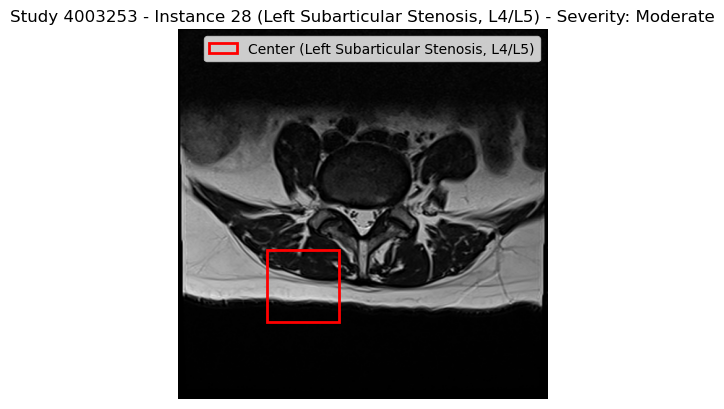

In [15]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Severity label mapping
id2label = {0: 'Normal/Mild', 1: 'Moderate', 2: 'Severe'}


# Function to load and visualize the image with the coordinates and severity
def plot_image_with_coordinates(study_id, series_id, instance_number, x, y, condition, level):
    # Construct the path (adjust the path if necessary based on your directory structure)
    series_description = series_description_df.loc[
    (series_description_df['study_id'] == study_id) & 
    (series_description_df['series_id'] == series_id)]['series_description'].values[0]
    
    image_path = f'./rsna_output/cvt_png/{study_id}/{series_description}/{instance_number:03d}.png'
    
    if os.path.exists(image_path):
        # Load the image
        img = Image.open(image_path)
        
        # Modify the level to replace '/' with '_'
        level_modified = level.lower().replace("/", "_")
        
        # Retrieve the severity from the relevant column in the df DataFrame
        severity_column = f'{condition.lower().replace(" ", "_")}_{level_modified}'
        
        # Check if the column exists before attempting to access it
        if severity_column in df.columns:
            severity_id = df.loc[df['study_id'] == study_id, severity_column].values[0]
            severity_label = id2label[severity_id]  # Convert severity ID to label
        else:
            print(f"Severity column {severity_column} not found.")
            return
        
        # Flip the y-coordinate to match the bottom-left origin
        flipped_y = img.size[1] - y
        
        # Plot the image
        plt.imshow(img, cmap='gray')
        plt.gca().add_patch(plt.Rectangle((x-50, flipped_y-50), 100, 100, linewidth=2, edgecolor='red', facecolor='none', label=f"Center ({condition}, {level})"))
        plt.legend()
        plt.title(f'Study {study_id} - Instance {instance_number} ({condition}, {level}) - Severity: {severity_label}')
        plt.axis('off')
        plt.show()
    else:
        print(f"Image not found for Study {study_id}, Series_description {series_description}, Series {series_id}, Instance {instance_number}")

# Example: Plot one sample from the coordinates dataframe
# Choosing a known sample
study_id_value = 4003253
condition_value = CONDITIONS[3]
level_value = LEVELS[3]

sample = coordinates_df.loc[
    (coordinates_df['study_id'] == study_id_value) & 
    (coordinates_df['condition'] == condition_value) & 
    (coordinates_df['level'] == level_value)
]

plot_image_with_coordinates(
    sample['study_id'].values[0], 
    sample['series_id'].values[0], 
    sample['instance_number'].values[0], 
    sample['x'].values[0], 
    sample['y'].values[0], 
    sample['condition'].values[0], 
    sample['level'].values[0]
)


## Improoving the Visualization

In [16]:
# Function to retrieve coordinates for a particular slice
def get_coordinates(study_id, instance_number):
    match = coordinates_df[(coordinates_df['study_id'] == study_id) &
                           (coordinates_df['instance_number'] == instance_number)]
    
    if not match.empty:
        return match['x'].values[0], match['y'].values[0], match['series_id'].values[0]  # Return the first match
    else:
        return None, None, None  # No coordinates found for this slice



/tmp/ipykernel_159/3162704239.py:45: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image_frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


NameError: name 'frames' is not defined

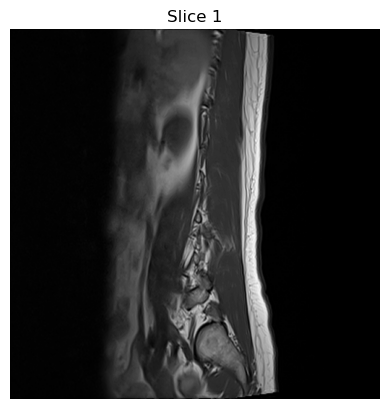

In [17]:
# Testing DataLoader
tmp_ds = RSNA24Dataset(df, phase='train', transform=transforms_val)
tmp_dl = DataLoader(
            tmp_ds,
            batch_size=2,
            shuffle=False,
            pin_memory=True,
            drop_last=False,
            num_workers=0
            )

# We assume 'df' is the same DataFrame with 'study_id' column
for i, (x, t) in enumerate(tmp_dl):
    if i == 2:  # Limiting to 1 batch for now
        break
    
    # Convert tensor to numpy for visualization
    image_3d = x.numpy().transpose(0, 2, 3, 1)[0, ...]  # First image in the batch
    study_id = df.iloc[i]['study_id']  # Use study_id from df
    
    # Normalize the image for visualization
    image_3d = (image_3d - image_3d.min()) / (image_3d.max() - image_3d.min())
    
    # Create frames for each slice
    for slice_idx in range(image_3d.shape[-1]):  # Iterating over all channels
        fig, ax = plt.subplots()
        ax.imshow(image_3d[..., slice_idx], cmap='gray')
        
        # Get the instance_number (slice) from the current index
        instance_number = slice_idx + 1
        
        # Get the coordinates and series_id for this slice
        x_coord, y_coord, series_id = get_coordinates(study_id, instance_number)
        
        # If valid coordinates are found, plot them
        if x_coord is not None and y_coord is not None:
            ax.scatter(x_coord, y_coord, color='red', s=100, label=f"Center ({series_id})")
            ax.legend()
        
        ax.set_title(f'Slice {slice_idx + 1}')
        plt.axis('off')

        # Save frame to an image in memory (without showing)
        fig.canvas.draw()
        image_frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image_frame = image_frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        
        frames.append(image_frame)  # Append RGB frame
        
        plt.close(fig)


In [ ]:
# Ensure `ffmpeg` is used for video writing with proper parameters
writer = imageio.get_writer(output_video, fps=5, codec='libx264')

# Write the video with the frames
for frame in frames:
    writer.append_data(frame)
writer.close()

# Function to display the video inline
def display_video(video_path):
    video_file = open(video_path, "rb").read()
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f'<video width="600" height="400" controls><source src="{video_url}" type="video/mp4"></video>')

# Display the video
display_video(output_video)

## Conclusions

# Lumbar Spine MRI Dataset Overview

## Key CSV Files

#####
1. `train.csv`
Contains severity labels for different lumbar spine conditions across vertebral levels, identified by `study_id`.

##### 
2. `train_series_descriptions.csv`
Maps `study_id` to `series_id` and provides the `series_description` (e.g., `Axial T2`, `Sagittal T2/STIR`).

##### 
3. `train_label_coordinates.csv`
Contains the x/y coordinates of annotated conditions for each `study_id`, mapped by `series_id` and `instance_number`.

## Image Directory Structure
The images are stored in:

./rsna_output/cvt_png/'study_id'/'series_description'/'instance_number'



The x/y coordinates in `train_label_coordinates.csv` likely use a bottom-left origin for the annotations.

